# METODI

## Vengono importate le librerie necessarie ed i dati di studio

In [1]:
import os
import math
import numpy as np
from pandas import *
import pandas as pd
from datetime import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import norm
from scipy.stats import genextreme,gumbel_r
from numpy import linspace
from pylab import plot,show,hist,figure,title
import matplotlib.pyplot as plt
from scipy.stats import genextreme,gumbel_r
from scipy.optimize import least_squares

# Importazione dei dati di studio

data = pd.ExcelFile('DatiCastelNuovoGarda.xlsx')
data.sheet_names
data=data.parse('Foglio1', header=2)
data.columns
data.rename(columns={'Unnamed: 0':'Anno'}, inplace=True)
data.rename(columns={'mm':'1h'}, inplace= True)
data.rename(columns={'mm.1':'3h'}, inplace= True)
data.rename(columns={'mm.2':'6h'}, inplace= True)
data.rename(columns={'mm.3':'12h'}, inplace= True)
data.rename(columns={'mm.4':'24h'}, inplace= True)
data.set_index('Anno', inplace= True)

# 1) METODO DEI MOMENTI
Questo metodo consiste nell'uguagliare i momenti del campione con i momenti della popolazione, in modo da stabilire i parametri a e b della curva di Gumbel. 
I momenti, in questo caso, sono la media e la varianza.

Per cui di $H$, è:
$$ E[H;a,b] = b \gamma + a $$
dove $\gamma = 0.572$ è il numero irrazionale detto di Eulero-Mascheroni.
Il valore della varianza è invece:
$$ Var[H;a,b] = b^2 \frac{\pi^2}{6}$$


Il metodo dei momenti si riduce alla risoluzione di:
\begin{equation}
\left\{
\begin{array}{l}
b \gamma + a = \mu_H \\
\sigma^2_H = b^2  \frac{\pi^2}{6}
\end{array}
\right.
\end{equation}
dove $a$ e $b$ sono i parametri da stimare $mu_H$ è la media del campioni di dati e $\sigma_H$ è la deviazione standard dei medesimi dati. 
Dalla seconda equazione si ricava:
\begin{equation}
b = \frac{\sqrt{6}}{\pi} \sigma_H
\end{equation}
che, sostituito nella prima equazione, dà:
\begin{equation}
a = \mu_H -\frac{\sqrt{6}\gamma}{\pi} \sigma_H 
\end{equation}

### Calcolo delle variabili per risolvere il sistema dei momenti

In [2]:
means=data.mean() #media
variances=data.var() #varianza 
stds=data.std() #deviazione standard
cv=data.std()/data.mean()  #coeffciente di variazione 
teta=math.sqrt(6)/math.pi #radice di 6/pi greco
EulerGamma=0.577215664901532860606512090
phi=teta*EulerGamma 
t_rain=np.linspace(data.min()[0],data.max()[4],100)

### Definita la funzione Gumbel e risolto il sistema dei momenti

La curva di Gumbel è una curva che ci permette di calcolare la probabilità che non si verifichi un evento, di durata assegnata, con altezza di precipitazione superiore ad una determinata altezza. 

Questa è l'espressione della curva di Gumbel contenente i parametri a e b
$$ P[H<h; a,b] = e^{-e^{-\frac{h-a}{b}}}$$

In [3]:
# funzione di Gumbel
def g(means,stds):
    return pd.DataFrame([means-phi*stds,teta*stds],index=["a","b"]) 
abs_m=g(means,stds)

# Salvato il file nella cartella

abs_m.to_pickle("abs_m")

# calcolo della funzione di gumbel con i parametri appena calcolati con metodo dei momenti

def gumbel(h,abs_m,col): 
    return np.exp(-np.exp(-(h-abs_m[col]["a"])/abs_m[col]["b"]))


### Grafico delle curve di Gumbel


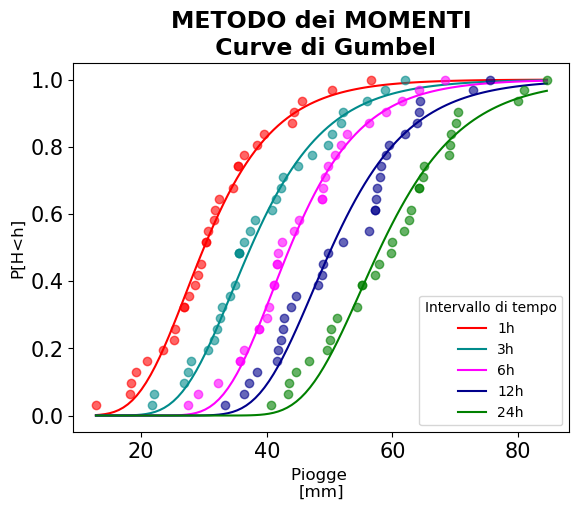

In [4]:
gb=pd.DataFrame([gumbel(t_rain,abs_m,"1h"),
                 gumbel(t_rain,abs_m,"3h"),
                 gumbel(t_rain,abs_m,"6h"),
                 gumbel(t_rain,abs_m,"12h"),
                 gumbel(t_rain,abs_m,"24h")]).T

gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
ax=gb.plot(color=["red","darkcyan","magenta","darkblue","green"])
ecdf1h = ECDF(data["1h"]) 
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red", alpha=0.6)
data3h=data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="darkcyan", alpha=0.6)
data6h=data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="magenta",  alpha=0.6)
data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="darkblue",  alpha=0.6)
data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"o",c="green", alpha=0.6)
ax.set_title('METODO dei MOMENTI\n Curve di Gumbel', fontweight='bold', fontsize='17')
ax.set_xlabel('Piogge \n[mm]', fontsize='12')
ax.set_ylabel('P[H<h]', fontsize='12')
plt.legend(title = "Intervallo di tempo")

# 2) METODO della MASSIMA VEROSOMIGLIANZA

Questo metodo permette calcolare i parametri a, b della curva di Gumbel massimizzando la probabilità congiunta dei singoli dati, i quali vengono considerati indipendenti tra loro $\{h_1, \cdot \cdot, h_n \}$ :
\begin{equation}
{\rm argmax}_{a,b} P[\{h_1, \cdot \cdot, h_n \};a,b] = {\rm argmax}_{a,b} \prod_i^n P[h_i;a,b]
\end{equation}

L'ipotesi di eventi indipendenti è generalmente verificata per le precipitazioni ma non è sempre detto sia vera. 

## Fitting dei dati con la funzione di Gumbel

In [5]:
samp = data["1h"]
param1h = gumbel_r.fit(samp)
samp = data["3h"].dropna()
param3h = gumbel_r.fit(samp) 
samp = data["6h"].dropna()
param6h = gumbel_r.fit(samp) 
samp = data["12h"].dropna()
param12h = gumbel_r.fit(samp) 
samp = data["24h"].dropna()
param24h = gumbel_r.fit(samp) 
abs_mle=pd.DataFrame([param1h,param3h,param6h,param12h,param24h],
                     columns=["a","b"],
                     index=["1h","3h","6h","12h","24h"]).T

#Salvato il file nella cartella 

abs_mle.to_pickle("abs_mle")

#calcolo della funzione di Gumbel con i parametri appena calcolati con metodo della massima verosomiglianza

def gumbel(x,abs_mle,col):
    return np.exp(-np.exp(-(x-abs_mle[col]["a"])/abs_mle[col]["b"]))

### Grafico delle curve di Gumbel

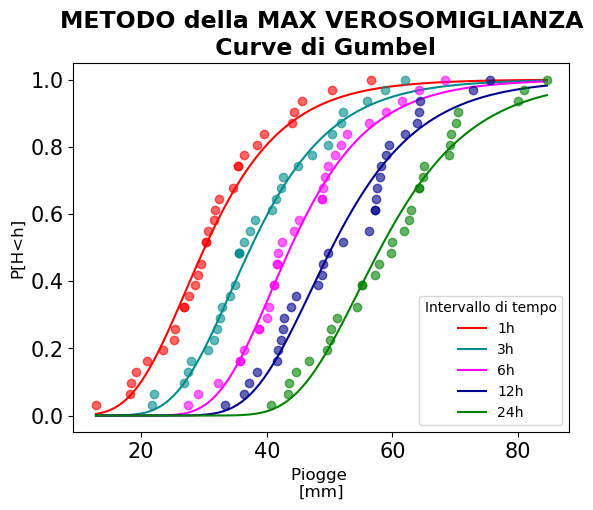

In [6]:
gb=pd.DataFrame([gumbel(t_rain,abs_mle,"1h"),
                 gumbel(t_rain,abs_mle,"3h"),
                 gumbel(t_rain,abs_mle,"6h"),
                 gumbel(t_rain,abs_mle,"12h"),
                 gumbel(t_rain,abs_mle,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
ax=gb.plot(color=["red","darkcyan","magenta","darkblue","green"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red", alpha=0.6)
data3h=data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="darkcyan", alpha=0.6)
data6h=data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="magenta", alpha=0.6)
data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="darkblue", alpha=0.6)
data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"o",c="green", alpha=0.6)
ax.set_title('METODO della MAX VEROSOMIGLIANZA\n Curve di Gumbel', fontweight='bold', fontsize='17')
ax.set_xlabel('Piogge \n[mm]', fontsize='12')
ax.set_ylabel('P[H<h]', fontsize='12')
plt.legend(title = "Intervallo di tempo")

# 3) METODO dei MINIMI QUADRATI

Questo metodo permette di calcolare i parametri a e b della curva di Gumbel definendo lo scarto quadratico tra le misure di ECDF (empirical cumulative distribution function) e la probabilità di non superamento. Tramite il seguente problema di ottimizzazione si cerca come soluzione il valore minimo dello scarto quadratico:

\begin{equation} 
\delta^2(a,b) = \sum_i^N (ECDF_i-P[h_i;a,b])^2 \to \rm min 
\end{equation}

## Risolvo la funzione $\delta^2(a,b)$

In [7]:
# Costruita la funzione fun in funzione delle variabili x, t, y

def fun(x, t, y):
    return np.exp(-np.exp(-(t-x[0])/x[1]))-y
x_1=[30.,9.]
t_train_1=sorted(data["1h"])
y_train_1=ecdf1h(t_train_1)
res_lsq_1h = least_squares(fun, x_1, args=(t_train_1, y_train_1))
x_3=[39.,10.]
t_train_3=sorted(data["3h"].dropna())
y_train_3=ecdf3h(t_train_3)
res_lsq_3h = least_squares(fun, x_3, args=(t_train_3, y_train_3))
ecdf6h = ECDF(data["6h"])
x_6=[48.,12.]
t_train_6=sorted(data["6h"].dropna())
y_train_6=ecdf6h(t_train_6)
res_lsq_6h = least_squares(fun, x_6, args=(t_train_6, y_train_6))
ecdf12h = ECDF(data["12h"])
x_12=[60.,18.]
t_train_12=sorted(data["12h"].dropna())
y_train_12=ecdf12h(t_train_12)
res_lsq_12h = least_squares(fun, x_12, args=(t_train_12, y_train_12))
ecdf24h = ECDF(data["24h"].dropna())
x_24=[75.,24.]
t_train_24=sorted(data["24h"].dropna())
y_train_24=ecdf24h(t_train_24)
res_lsq_24h = least_squares(fun, x_24, args=(t_train_24, y_train_24))
res_lsq_1h.x
res_lsq_3h.x
res_lsq_6h.x
res_lsq_12h.x
res_lsq_24h.x

abs_mq=pd.DataFrame([res_lsq_1h.x,res_lsq_3h.x,res_lsq_6h.x,res_lsq_12h.x,res_lsq_24h.x],columns=["a","b"],
                     index=["1h","3h","6h","12h","24h"]).T
# salvato il file nella cartella 

abs_mq.to_pickle("abs_mq")

# Calcolo della funzione di Gumbel con i parametri appena calcolati con metodo dei minimi quadrati

def gumbel(x,abs_mq,col):
    return np.exp(-np.exp(-(x-abs_mq[col]["a"])/abs_mq[col]["b"]))

### Grafico delle curve di Gumbel

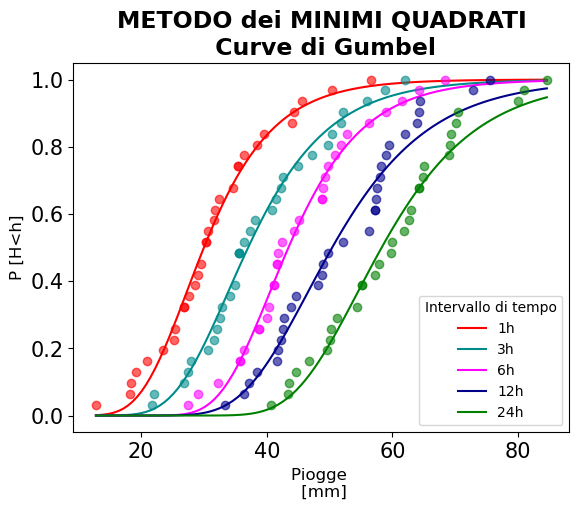

In [8]:
gb=pd.DataFrame([gumbel(t_rain,abs_mq,"1h"),
                 gumbel(t_rain,abs_mq,"3h"),
                 gumbel(t_rain,abs_mq,"6h"),
                 gumbel(t_rain,abs_mq,"12h"),
                 gumbel(t_rain,abs_mq,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15) 
 
ax=gb.plot(color=["red","darkcyan","magenta","darkblue","green"])
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red", alpha=0.6)
data3h=data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="darkcyan", alpha=0.6)
data6h=data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="magenta", alpha=0.6)
data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="darkblue", alpha=0.6)
data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"o",c="green", alpha=0.6)
ax.set_title('METODO dei MINIMI QUADRATI\n Curve di Gumbel', fontweight='bold', fontsize='17')
ax.set_xlabel('Piogge \n [mm]', fontsize='12')
ax.set_ylabel('P [H<h]', fontsize='12')
plt.legend(title = "Intervallo di tempo")

# TEST di PEARSON

Dopo aver ricavato le curve per ogni metodo, viene svolto il test di Pearson. 

Viene utilizzato per capire quale tra queste tre coppie di parametri sia in assoluto la migliore.
Questo è un test non parametrico e consiste nel suddividere le curve di probabilità in k intervalli.

Ci si aspetta che, in ogni intervallo, con limite destro h1h, ci siano $e=(l1h * q)$ elementi mentre ce ne sono  in realtà $o=(l1h * r)$.  La formula dell'$X^2$ è allora:
\begin{equation}
X^2 = \frac{1}{e}\sum_{i=1}^k (e - o)^2
\end{equation}


### Importati i file dai diversi metodi.

In [9]:
# file salvati nella cartella relativi ai parametri a, b dei diversi metodi.
abs_m=pd.read_pickle("abs_m")
abs_mq=pd.read_pickle("abs_mq")
abs_mle=pd.read_pickle("abs_mle")
abs_m.at["a","1h"]
rv=gumbel_r(loc=abs_m.at["a","1h"],scale=abs_m.at["b","1h"])
q=[0.2,0.4,0.6,0.8,1]
h1h=rv.ppf(q)
ecdf1h = ECDF(data["1h"])
r=ecdf1h(h1h)
l1h=len(data["1h"])
o0=l1h*r
np.append([0],np.delete(o0,-1))
o=o0-np.append([0],np.delete(o0,-1))
range(len(r))
# Costruiti i parametri per risolvere la funzione del test del X^2

e=[0.2*l1h for i in range(len(r))]
o-e
(o-e)**2
(o-e)**2/e
((o-e)**2/e).sum()

# Definita la funzione X^2

def X2(data,abs_t,h,delta):    
    dt=data[h].dropna()
    lh=len(dt)
    q=[delta*(i+1) for i in range(int(1/delta))]
    rv=gumbel_r(loc=abs_t.at["a",h],scale=abs_t.at["b",h])
    ecdf = ECDF(dt)
    r=ecdf(rv.ppf(q))
    o0=lh*r
    o=o0-np.append([0],np.delete(o0,-1))
    e=[delta*lh for i in range(len(r))]
    return ((o-e)**2/e).sum()  

# Applicazione del test alle varie durate dei diversi metodi 

X2(data,abs_m,"1h",0.2)
X2(data,abs_mq,"1h",0.2)
X2(data,abs_mle,"1h",0.2)
a=[]

for  h in data.columns:
    print(h,": ",[X2(data,abs_m,h,0.2),X2(data,abs_mq,h,0.2),X2(data,abs_mle,h,0.2)])
for h in data.columns:
    a=a+[[X2(data,abs_m,h,0.2),X2(data,abs_mq,h,0.2),X2(data,abs_mle,h,0.2)]]
pd.DataFrame(a,index=["1h","3h","6h","12h","24h"],columns=["M","Mq","MLE"])
best=DataFrame([abs_mq["1h"],
                abs_m["3h"],
                abs_mle["6h"],
                abs_mq["12h"],
                abs_m["24h"]]).T
best.to_pickle("best_param")

# Calcolo della funzione di Gumbel con i migliori parametri ottenuti da ogni metodo.

def gumbel(x,abs_d,col):
    return np.exp(-np.exp(-(x-abs_d[col]["a"])/abs_d[col]["b"]))

1h :  [0.7741935483870944, 0.7741935483870944, 1.7419354838709666]
3h :  [0.7741935483870956, 1.0967741935483848, 0.45161290322580644]
6h :  [0.1290322580645173, 0.1290322580645173, 0.7741935483870956]
12h :  [5.612903225806448, 3.6774193548387037, 2.3870967741935485]
24h :  [2.7096774193548385, 3.6774193548387037, 2.064516129032258]


### Grafico delle curve di Gumbel

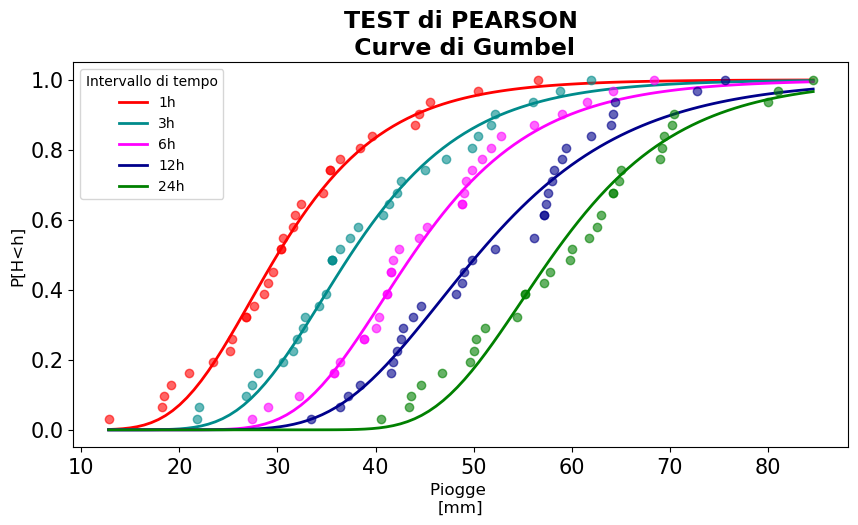

In [10]:
gb=pd.DataFrame([gumbel(t_rain,best,"1h"),
                 gumbel(t_rain,best,"3h"),
                 gumbel(t_rain,best,"6h"),
                 gumbel(t_rain,best,"12h"),
                 gumbel(t_rain,best,"24h")]).T
gb.index=t_rain
gb.columns=["1h","3h","6h","12h","24h"]
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
ax=gb.plot(color=["red","darkcyan","magenta","darkblue","green"], figsize=(10,5), lw=(2))
ecdf1h = ECDF(data["1h"])
ax.plot(data["1h"],ecdf1h(data["1h"]),'o',c="red", alpha=0.6)
data3h=data["3h"].dropna()
ecdf3h = ECDF(data3h)
ax.plot(data3h,ecdf3h(data3h),"o",c="darkcyan",alpha=0.6)
data6h=data["6h"].dropna()
ecdf6h = ECDF(data6h)
ax.plot(data6h,ecdf6h(data6h),"o",c="magenta", alpha=0.6)
data12h=data["12h"].dropna()
ecdf12h = ECDF(data12h)
ax.plot(data12h,ecdf12h(data12h),"o",c="darkblue", alpha=0.6)
data24h=data["24h"].dropna()
ecdf24h = ECDF(data24h)
ax.plot(data24h,ecdf24h(data24h),"o",c="green", alpha=0.6)
ax.set_title('TEST di PEARSON\n Curve di Gumbel', fontweight='bold', fontsize='17')
ax.set_xlabel('Piogge \n[mm]', fontsize='12')
ax.set_ylabel('P[H<h]', fontsize='12')
plt.legend(title = "Intervallo di tempo")